In [1]:
import keras
import numpy as np
from keras.models import Model
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.layers import Conv2D,Input,Reshape,Layer,Flatten,Lambda,Layer,Dense
from keras import backend as k
from keras import initializers
import tensorflow as tf
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
(x_train,y_orig_train),(x_test,y_orig_test)=mnist.load_data()

In [3]:
print("x_train shape     :"+"{:}".format(x_train.shape))
print("y_org_train shape :"+"{:}".format(y_orig_train.shape))
print("x_test            :"+"{:}".format(x_test.shape))
print("y_org_test shape  :"+"{:}".format(y_orig_test.shape))

x_train shape     :(60000, 28, 28)
y_org_train shape :(60000,)
x_test            :(10000, 28, 28)
y_org_test shape  :(10000,)


In [4]:
x_train=x_train.astype('float32')/255
x_train=x_train.reshape(-1,28,28,1)
print("x_train shape :",x_train.shape)
y_train=np.array(to_categorical(y_orig_train.astype('float32')))
print("y_train shape :",y_train.shape)

x_train shape : (60000, 28, 28, 1)
y_train shape : (60000, 10)


In [5]:
x_test=x_test.astype('float32')/255
x_test=x_test.reshape(-1,28,28,1)
print("x_test shape :",x_test.shape)
y_test=np.array(to_categorical(y_orig_test.astype('float32')))
print("y_test shape :",y_test.shape)

x_test shape : (10000, 28, 28, 1)
y_test shape : (10000, 10)


In [6]:
n=5

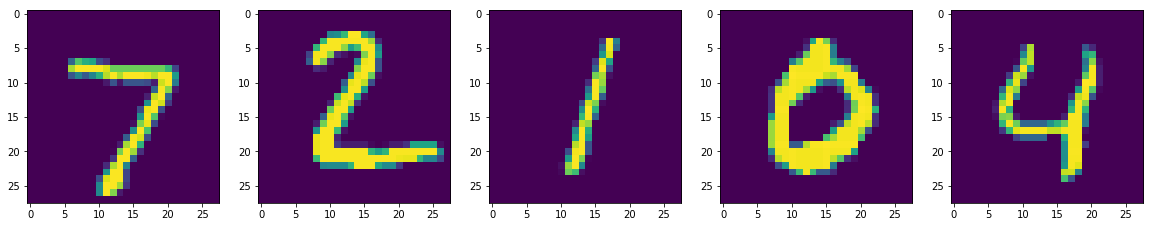

In [7]:
plt.figure(figsize=(20,5))
for i in range(5):
    plt.subplot(1,n,i+1)
    img=x_test[i].reshape(28,28)
    plt.imshow(img)
    

In [8]:
inp=Input(shape=(28,28,1))
#convolution layer shape conv1 - 20*20*256
conv1=Conv2D(256,(9,9),activation="relu",padding="valid")(inp)

#PRIMARY CAPSULE LAYER

#convolution layer shape conv2 - 6*6*256
conv2=Conv2D(256,(9,9),strides=2,padding="valid")(conv1)
#vector of dimension  6*6*32,8
reshaped=Reshape((6*6*32,8))(conv2)

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
def squash(inputs):
    square_norm = k.sum(k.square(inputs),axis=-1,keepdims=True)
    return ((square_norm/(1+square_norm))/(k.sqrt(square_norm+k.epsilon())))*inputs
squashed_output = Lambda(squash)(reshaped)

In [10]:
class DigitCapsuleLayer(Layer):   #0,1158,8
    def __init__(self,**kwargs):
        super(DigitCapsuleLayer,self).__init__(**kwargs)
        self.kernel_initializer=initializers.get('glorot_uniform')
    
    #initialize weight matrix for each capsule in lower laye
    def build(self,input_shape):
        self.W=self.add_weight(shape=[10,6*6*32,16,8],initializer=self.kernel_initializer,name='weights')
        self.built=True
    
    #matrix multiplication b/w previous layer output and weight matrix 
    def call(self,inputs):
        inputs=k.expand_dims(inputs,1)
        inputs=k.tile(inputs,[1,10,1,1])
        inputs=k.map_fn(lambda x:k.batch_dot(x,self.W,[2,3]),elems=inputs)
        b=tf.zeros(shape=[k.shape(inputs)[0],10,6*6*32])
    
# routing algorithm with updating coupling coefficient c, 
#using scalar product b/w input capsule and output capsule
        for i in range(3-1):
            c=tf.nn.softmax(b,dim=1)
            s=k.batch_dot(c,inputs,[2,2])
            v=squash(s)
            b=b+k.batch_dot(v,inputs,[2,3])
        return v
    def compute_output_shape(self,input_shape):
        return tuple([None,10,16])
def output_layer(inputs):
    return k.sqrt(k.sum(k.square(inputs),-1)+k.epsilon())

In [11]:
digit_caps=DigitCapsuleLayer()(squashed_output)
outputs=Lambda(output_layer)(digit_caps)

Instructions for updating:
dim is deprecated, use axis instead


In [12]:
def mask(outputs):
 
    if type(outputs) != list:  # mask at test time
        norm_outputs = k.sqrt(k.sum(k.square(outputs), -1) + k.epsilon())
        y  = k.one_hot(indices=k.argmax(norm_outputs, 1), num_classes = 10)
        y = Reshape((10,1))(y)
        return Flatten()(y*outputs)
 
    else:    # mask at train time
        y = Reshape((10,1))(outputs[1])
        masked_output = y*outputs[0]
        return Flatten()(masked_output)
    
inputs = Input(shape = (10,))
masked = Lambda(mask)([digit_caps, inputs])
masked_for_test = Lambda(mask)(digit_caps)
 
decoded_inputs = Input(shape = (16*10,))
dense1 = Dense(512, activation = 'relu')(decoded_inputs)
dense2 = Dense(1024, activation = 'relu')(dense1)
decoded_outputs = Dense(784, activation = 'sigmoid')(dense2)
decoded_outputs = Reshape((28,28,1))(decoded_outputs)

In [13]:
def loss_fn(y_true, y_pred):
 
    L = y_true * k.square(k.maximum(0., 0.9 - y_pred)) + 0.5 * (1 - y_true) * k.square(k.maximum(0., y_pred - 0.1))
 
    return k.mean(k.sum(L, 1))

In [14]:
decoder = Model(decoded_inputs, decoded_outputs)
model = Model([inp,inputs],[outputs,decoder(masked)])
test_model = Model(inp,[outputs,decoder(masked_for_test)])
 
m = 128
epochs = 10
model.compile(optimizer=keras.optimizers.Adam(lr=0.001),loss=[loss_fn,'mse'],loss_weights = [1. ,0.0005],metrics=['accuracy'])
model.fit([x_train, y_train],[y_train,x_train], batch_size = m, epochs = epochs, validation_data = ([x_test, y_test],[y_test,x_test]))

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
  128/60000 [..............................] - ETA: 55:40 - loss: 0.8095 - lambda_2_loss: 0.8094 - model_1_loss: 0.2311 - lambda_2_acc: 0.0547 - model_1_acc: 0.8077

KeyboardInterrupt: 

In [ ]:
n_samples = 5

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    sample_image = x_test[index+5].reshape(28, 28)
    plt.imshow(sample_image, cmap="binary")
    plt.title("Label:" + str(y_orig_test[index]))
    plt.axis("off")

plt.show()

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    sample_image = image_predicted[index+5].reshape(28, 28)
    plt.imshow(sample_image, cmap="binary")
    plt.title("Predicted:" + str(np.argmax(label_predicted[index])))
    plt.axis("off")

plt.show()